# ***Fake News Detection*** – Deep Learning

In this final section, we'll train and tune a deep learning model to evaluate whether it outperforms traditional approaches for this task.

Given the nature of this dataset, we'll use `DistilBERT`, a lightweight and efficient transformer model known for delivering strong NLP performance with faster training times.

In [ ]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

from transformers import (
    DistilBertTokenizerFast,
    AutoModelForSequenceClassification,
    get_scheduler,
)

from transformers_interpret import SequenceClassificationExplainer

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)

In [ ]:
import importlib

sys.path.append(os.path.abspath(os.getcwd()))

import utils.data_preprocess

importlib.reload(utils.data_preprocess)

from utils.data_preprocess import run_pipeline

Even though the model is lighter and faster than many alternatives, the dataset is quite massive and this machine is not handling it in a reasonable amount of time. That's why we had to be able to run it on Google Colab for training.

In [ ]:
RUNNING_IN_COLAB = "google.colab" in sys.modules

if RUNNING_IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

BASE_DIR = "/content/drive/MyDrive/fake_news" if RUNNING_IN_COLAB else "./"
DATA_PATH = os.path.join(BASE_DIR, "dataset/news_data.csv")
LOGS_DIR = os.path.join(BASE_DIR, "logs/")
MODEL_DIR = os.path.join(BASE_DIR, "models/")
MODEL_PATH = os.path.join(MODEL_DIR, "model.pt")

os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [5]:
SEED = 87

### ***1. Data Preparation***

Dataset loading

In [ ]:
news_data_dl = pd.read_csv(DATA_PATH, dtype={6: str, 7: str})[
    ["clean_text", "fake"]
].copy()

We will rename `fake` column to `label`

In [7]:
news_data_dl["label"] = news_data_dl["fake"].astype(int)

And we shuffle the dataset

In [ ]:
df = news_data_dl.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [9]:
df.head()

,clean_text,fake,label
0,Would a Hillary Clinton Presidency Mean More W...,1,1
1,Major Corporation Leaves South Carolina After ...,1,1
2,Kremlin says hopes Comey firing will not hurt ...,0,0
3,"Trump advisers push him to target OPEC, regula...",0,0
4,"Eying snap election, Japan's Abe to focus on e...",0,0


We define a custom PyTorch dataset class to prepare news text and labels for DistilBERT by tokenizing each article and returning the tensors needed for training or prediction.

In [10]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.texts = dataframe["clean_text"].tolist()
        self.labels = dataframe["label"].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(),
            "attention_mask": encoded["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

    def __len__(self):
        return len(self.labels)

We set up a PyTorch Lightning data module that splits the dataset into training, validation and test sets, preparing them using the NewsDataset class and creating efficient DataLoaders for model training and evaluation.

In [ ]:
class NewsDataModule(pl.LightningDataModule):
    def __init__(self, dataframe, tokenizer, batch_size=16):
        super().__init__()
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        train, test = train_test_split(
            dataframe, test_size=0.2, stratify=dataframe["label"], random_state=SEED
        )
        self.train_df, self.val_df = train_test_split(
            train, test_size=0.2, stratify=train["label"], random_state=SEED
        )
        self.test_df = test

    def setup(self, stage=None):
        self.train_data = NewsDataset(self.train_df, self.tokenizer)
        self.val_data = NewsDataset(self.val_df, self.tokenizer)
        self.test_data = NewsDataset(self.test_df, self.tokenizer)

    def train_dataloader(self):
        return DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2 if RUNNING_IN_COLAB else 0,
            persistent_workers=RUNNING_IN_COLAB,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_data,
            batch_size=self.batch_size,
            num_workers=2 if RUNNING_IN_COLAB else 0,
            persistent_workers=RUNNING_IN_COLAB,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_data,
            batch_size=self.batch_size,
            num_workers=2 if RUNNING_IN_COLAB else 0,
            persistent_workers=RUNNING_IN_COLAB,
        )

### ***2. Model Definition***

We define a wrapper for a fine-tuned DistilBERT model for binary text classification. 
It handles training, validation, testing, and optimization, logs key metrics and adjusts learning rate.
We will not be freezing layers, since it is requested an End-2-end approach.

In [ ]:
class DistilBertClassifier(pl.LightningModule):
    def __init__(self, lr=2e-5, num_labels=2):
        super().__init__()
        self.save_hyperparameters()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased", num_labels=num_labels
        )
        self.val_preds = []
        self.val_labels = []

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        lr = self.trainer.optimizers[0].param_groups[0]["lr"]
        self.log("train_loss", outputs.loss, prog_bar=True)
        self.log("lr", lr)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        preds = outputs.logits.argmax(dim=1)
        self.val_preds.append(preds)
        self.val_labels.append(batch["labels"])
        return outputs.loss

    def on_validation_epoch_end(self):
        preds = torch.cat(self.val_preds)
        labels = torch.cat(self.val_labels)

        acc = accuracy_score(labels.cpu(), preds.cpu())
        f1 = f1_score(labels.cpu(), preds.cpu())
        precision = precision_score(labels.cpu(), preds.cpu())
        recall = recall_score(labels.cpu(), preds.cpu())

        self.log_dict(
            {
                "val_acc": acc,
                "val_f1": f1,
                "val_precision": precision,
                "val_recall": recall,
            },
            prog_bar=True,
        )

        self.val_preds.clear()
        self.val_labels.clear()

    def test_step(self, batch, batch_idx):
        outputs = self(**batch)
        preds = outputs.logits.argmax(dim=1)
        probs = outputs.logits.softmax(dim=1)[:, 1].detach().cpu().numpy()
        labels = batch["labels"]
        self.log("test_acc", accuracy_score(labels.cpu(), preds.cpu()), prog_bar=True)
        self.log("test_f1", f1_score(labels.cpu(), preds.cpu()), prog_bar=True)
        self.log("test_precision", precision_score(labels.cpu(), preds.cpu()))
        self.log("test_recall", recall_score(labels.cpu(), preds.cpu()))
        self.log("test_auc", roc_auc_score(labels.cpu(), probs))

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [
                    p
                    for n, p in self.named_parameters()
                    if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.01,
            },
            {
                "params": [
                    p
                    for n, p in self.named_parameters()
                    if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.lr)

        steps_per_epoch = len(self.trainer.datamodule.train_dataloader())
        total_training_steps = steps_per_epoch * self.trainer.max_epochs
        warmup_steps = int(0.1 * total_training_steps)

        scheduler = get_scheduler(
            name="linear",
            optimizer=optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_training_steps,
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

In [14]:
data_module = NewsDataModule(df, tokenizer, batch_size=16)
model = DistilBertClassifier()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
logger = CSVLogger(save_dir=LOGS_DIR, name="bert_logs")
checkpoint = ModelCheckpoint(
    dirpath=LOGS_DIR, monitor="val_f1", mode="max", save_top_k=1, filename="best_model"
)
early_stop = EarlyStopping(monitor="val_f1", mode="max", patience=2)

### ***3. Model Training***

We will define an initial small amount of epochs, we can increase it if needed.

In [ ]:
trainer = pl.Trainer(
    max_epochs=6,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    precision="16-mixed" if torch.cuda.is_available() else 32,
    callbacks=[checkpoint, early_stop],
    logger=logger,
    log_every_n_steps=10,
    accumulate_grad_batches=2,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

Now we save the model to be able to load it whenever needed.

In [ ]:
torch.save(model.model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

✅ Model saved to /content/drive/MyDrive/fake_news/models/model.pt


### ***4. Model Evaluation***

Let's have a look at the metrics saved during training process. We will load the lates saved file from logs directory.

In [19]:
LOGS_ROOT = os.path.join(LOGS_DIR, "bert_logs/")
versions = [d for d in os.listdir(LOGS_ROOT) if d.startswith("version_")]
latest_version = sorted(versions, key=lambda x: int(x.split("_")[1]))[-1]
log_path = os.path.join(LOGS_ROOT, latest_version, "metrics.csv")

logs_df = pd.read_csv(log_path)
logs_df = logs_df.drop_duplicates(subset=["epoch", "step"]).reset_index(drop=True)

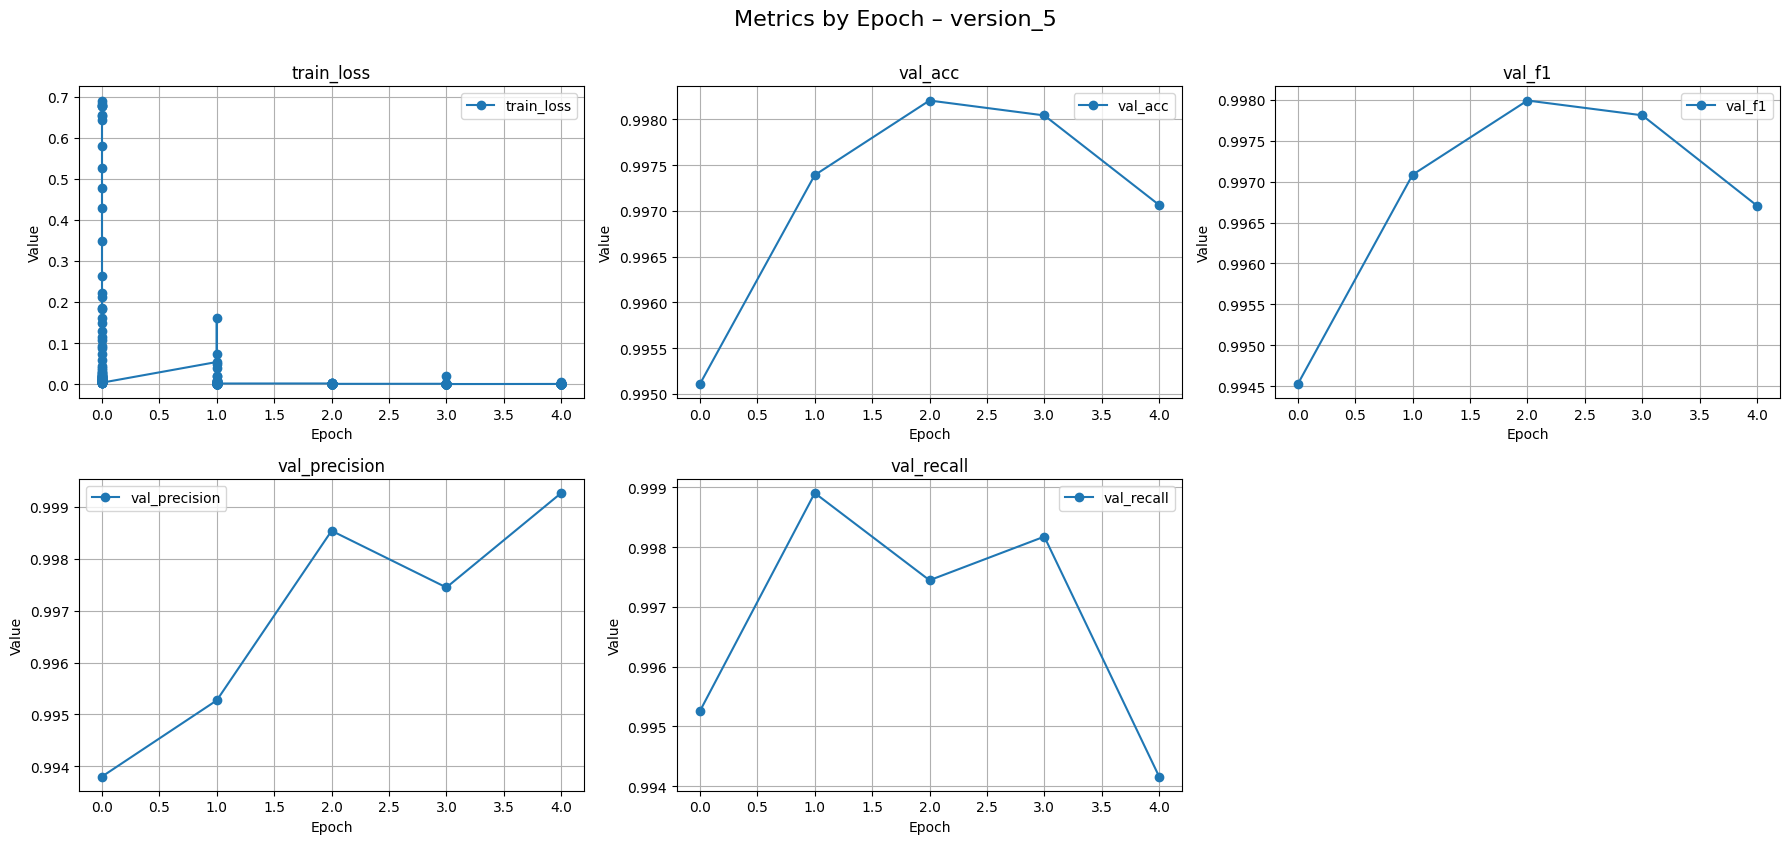

In [ ]:
metrics_to_plot = ["train_loss", "val_acc", "val_f1", "val_precision", "val_recall"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    if metric in logs_df.columns and logs_df[metric].notna().any():
        axes[i].plot(
            logs_df["epoch"][logs_df[metric].notna()],
            logs_df[metric].dropna(),
            marker="o",
            label=metric,
        )
        axes[i].set_title(metric)
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel("Value")
        axes[i].grid(True)
        axes[i].legend()

for j in range(len(metrics_to_plot), 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle(f"Metrics by Epoch – {latest_version}", fontsize=16, y=1.05)
plt.show()

The training curve shows that the DistilBERT model is learning extremely well, suspiciously too well. Training loss drops to near-zero very quickly, and all metrics (accuracy, F1, precision, and recall) stay extremely high across all epochs. This may indicate either excellent generalization or potential overfitting if the dataset is too easy or unbalanced. Interestingly, while most metrics peak around epoch 2 or 3, there's a small dip at epoch 4, especially in recall, suggesting that early stopping might have helped catch the best checkpoint a bit earlier.

### ***5. Test Prediction***

The model seems to have incredibly good performances on validation set, we should expect a similar behavior for test set.

In [ ]:
model.model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()

In [ ]:
dm = NewsDataModule(df, tokenizer)
dm.setup()

test_loader = dm.test_dataloader()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [22]:
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

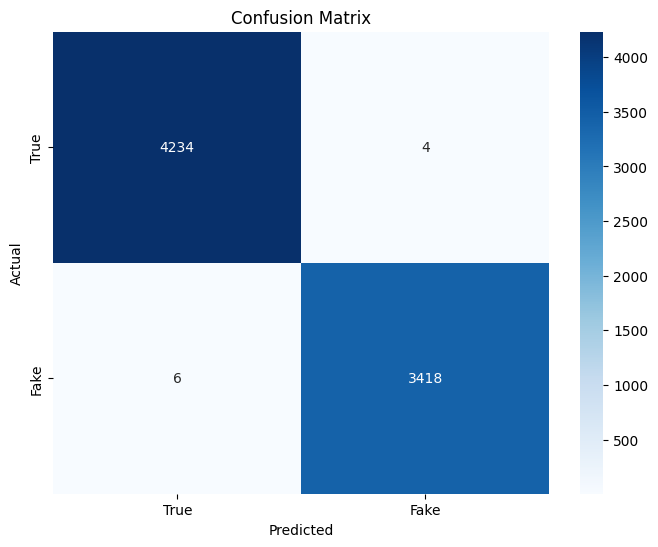

In [ ]:
cm_synth = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_synth,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["True", "Fake"],
    yticklabels=["True", "Fake"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

The previous models were performing well, but this one is nearly perfect. 

### ***6. Misprediction Analysis***

We will select 5 mispredicted news and evaluate them with `SequenceClassificationExplainer`

In [49]:
wrong_preds = []

for i, (pred, label) in enumerate(zip(all_preds, all_labels)):
    if pred != label:
        # Recover the original input text from the test set
        batch_idx = i // test_loader.batch_size
        sample_idx = i % test_loader.batch_size

        # Re-load the corresponding batch (you can optimize this by caching)
        batch = list(test_loader)[batch_idx]
        input_ids = batch["input_ids"][sample_idx]

        # Decode to text
        text = tokenizer.decode(input_ids, skip_special_tokens=True)
        wrong_preds.append((text, pred, label))

In [50]:
wrong_preds[:5]

[('northern ireland life inside the fountain sep william jackson remembers the exodus vividly, when over 10, 000 protestants fled the west bank of londonderry s river foyle for the city s suburbs as northern ireland s troubles erupted. almost 50 years on jackson is among some 250 protestants who stayed and carved out a tiny enclave known as the fountain, a tight, fiercely pro - british community that is separated by high walls and fences from the surrounding irish nationalist heartland. you are not talking one or two families, you are talking hundreds and hundreds and hundreds, jackson said, recalling the flight which began in 1969 when british troops were sent to the city to quell unrest over a civil rights campaign launched by the catholic minority. three decades of bloodshed followed between catholic irish nationalists, seeking to unite with ireland, and pro - british protestant loyalists, who want to remain part of the united kingdom. around 3, 600 people were killed before a 1998 

In [ ]:
explainer = SequenceClassificationExplainer(model=model.model, tokenizer=tokenizer)

false_negative = wrong_preds[1][0]
word_attributions = explainer(false_negative)

_ = explainer.visualize()

In [ ]:
false_positive = wrong_preds[2][0]
word_attributions = explainer(false_positive)

_ = explainer.visualize()

The visual inspection shows that the text has been tokenized, but some of the most relevant tokens are hard to understand. We still see that timeline and location positioning are important as well as events and persons. But the word `said` might have positinve or negative influence.

### ***7. Test With External Data***

As done with previous models we will try to run the model on a synthetic dataset. This time we don't rely on numerical features, so we might expect different results.

In [ ]:
synthetic_data = pd.read_csv("dataset/synthetic_news.csv")

We now need to run the initial text cleaning.

In [ ]:
synthetic_data_preprocessed = run_pipeline(synthetic_data, "text")
synthetic_data_preprocessed["label"] = synthetic_data_preprocessed["fake"].astype(int)
synth_df = synthetic_data_preprocessed[["clean_text", "label"]].copy()

In [36]:
synth_df.head()

,clean_text,label
0,You wont believe what they just decided at the...,1
1,You wont believe what they just decided at the...,1
2,dw The Iran protests ended after a week of neg...,0
3,You wont believe what they just decided at the...,1
4,reuters The US midterm elections concluded wit...,0


Then create Dataset and DataLoader

In [41]:
synth_dataset = NewsDataset(synth_df, tokenizer)
synth_loader = DataLoader(synth_dataset, batch_size=16)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Now we will predict from synthetic dataset

In [44]:
predictions = []
with torch.no_grad():
    for batch in synth_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)
        predictions.extend(preds.cpu().numpy())

synth_df["predicted_label"] = predictions

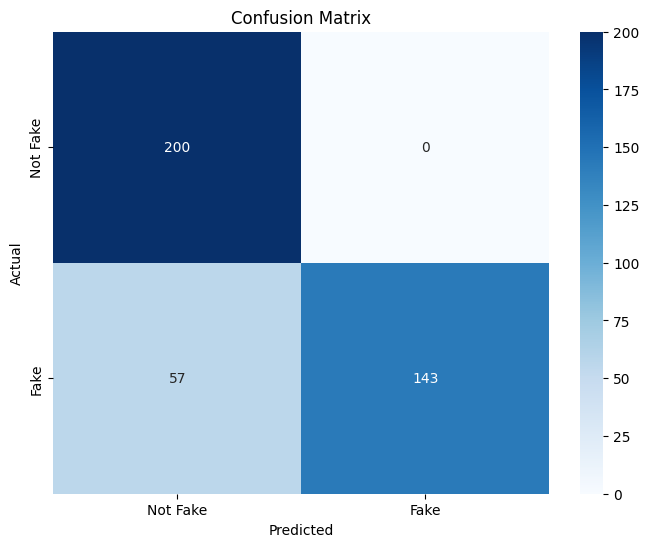

In [ ]:
cm = confusion_matrix(synth_df["label"], predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Fake", "Fake"],
    yticklabels=["Not Fake", "Fake"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report_dict = classification_report(synth_df["label"], predictions, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(3)

print("Classification Report:")
display(report_df)

Classification Report:


,precision,recall,f1-score,support
0,0.778,1.000,0.875,200.000
1,1.000,0.715,0.834,200.000
accuracy,0.858,0.858,0.858,0.858
macro avg,0.889,0.857,0.855,400.000
weighted avg,0.889,0.858,0.855,400.000


These results show that the model performs very well overall, especially in distinguishing between the two classes. It correctly identifies almost all samples of class 0 (`real news`), with perfect recall, meaning it misses no true samples of that class. Class 1 (`fake news`) is also predicted quite well, with very high precision (1.000), meaning nearly all predictions labeled as fake are indeed fake, though the recall drops to 0.715, indicating some fake news is still missed. The overall accuracy is strong at 85.8%, and both macro and weighted averages confirm balanced performance across the two classes. This is a solid result for a synthetic dataset.

Evaluating all the models, DistilBERT clearly outperforms the others on both the original and synthetic datasets. While Logistic Regression delivers comparable results on the original data, it does so with a fraction of the training time and without requiring a GPU. However, on the synthetic dataset, DistilBERT achieves performance scores around 20 points higher than the other models on average, making deep learning the superior choice in this scenario, despite the longer training times.

## ***Conclusions***

This analysis demonstrates the effectiveness of modern Natural Language Processing techniques in distinguishing between true and fake news articles. By comparing traditional machine learning models with a deep learning approach based on DistilBERT, we've shown that transformer-based models significantly outperform simpler baselines, both in terms of accuracy and robustness. 

From a business perspective, such a system could be integrated into content moderation pipelines for news aggregators, social media platforms, or fact-checking services, where early detection of misinformation is essential. In these domains, the speed of response becomes critical: detecting and flagging fake news before it gains traction can reduce the spread of misinformation, limit reputational damage, and support better-informed decision-making by the public.

However, real-world applications are rarely static. One of the biggest challenges will come from domain generalization. While this model performs very well on the current dataset, mostly made up of politically oriented news, its performance might degrade when dealing with other domains such as health, science, sports, finance or entertainment. Each of these fields comes with its own vocabulary, linguistic nuances, and types of misinformation. This could require continual fine-tuning or domain-specific adaptation.

Furthermore, traditional media often rely on clickbait strategies to boost engagement, blurring the line between sensationalism and misinformation. At the same time, advances in AI allow fake news creators to write in a more polished, authoritative tone, making false content harder to distinguish. This convergence complicates detection efforts, as both real and fake news can share similar styles, highlighting the need for smarter models that consider not just language, but also context and source credibility.

Another key insight from our misclassification analysis is that borderline or stylistically deceptive content remains difficult to classify. These are cases where the model's confidence is often low, and additional contextual signals could play a crucial role. Future iterations of this project might incorporate more thorough metadata features, source-based profiling, or multi-modal signals (like image verification) to reinforce the classification.

Finally, interpretability remains a vital component of any fake news detection system. While LIME and attention-based visualizations provide some insight into model reasoning, more work is needed to make these explanations accessible and actionable for end users or moderators. Transparent AI is especially important in sensitive domains such as journalism, politics, or public health, where the cost of false positives or negatives is high.

In summary, such models can become valuable allies in the fight against misinformation.